# Get the data

In [ ]:
import numpy as np 
import pandas as pd
from copy import deepcopy
from sklearn.metrics import mean_absolute_error
%matplotlib inline 
random_state=0

In [ ]:
# The data is provided by the Johns Hopkins University
# https://github.com/CSSEGISandData/COVID-19
df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
df = df[df["Country/Region"] == "US"]

In [ ]:
df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,10/27/22,10/28/22,10/29/22,10/30/22,10/31/22,11/1/22,11/2/22,11/3/22,11/4/22,11/5/22
260,NaN,US,40.0,-100.0,1,1,2,2,5,5,...,97417744,97447888,97456861,97460011,97503019,97550350,97622888,97692050,97729653,97734261


In [ ]:
# rawData contains the values of confirmed cases in the world
firstDateIndex = df.columns.get_loc("1/22/20")
rawData = [0 for i in range(firstDateIndex, df.shape[1])]
for i in range(df.shape[1] - firstDateIndex):
    rawData[i] = sum(df.iloc[:, i+firstDateIndex])

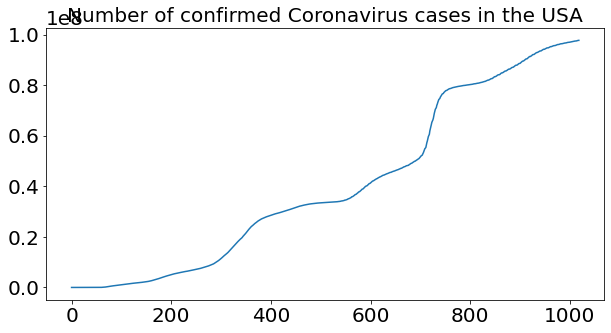

In [ ]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(10, 5))
plt.title('Number of confirmed Coronavirus cases in the USA', size=20)
plt.plot(range(len(rawData)), rawData)
plt.show()

### The data can be split in 2 parts: 
1. The linear part made of the first 50 elements 
2. The rest of the data which is non-linear

In [ ]:
originalData = deepcopy(rawData)
rawData = rawData[:]

In [ ]:
numberOfDaysToForcast = 7

In [ ]:
import datetime
numberOfAvailableDays = len(rawData)
print(numberOfAvailableDays) # Already has a number confirmed
numberOfDays = numberOfAvailableDays + numberOfDaysToForcast
numberOfDays
day1 = datetime.datetime.strptime('1/22/2020', '%m/%d/%Y')
print(day1)
day7 = day1 + datetime.timedelta(days=7)
print(day7)
availableDateRange = [day1+datetime.timedelta(days=x) for x in range(numberOfAvailableDays)]
TestDateRange = [availableDateRange[-1]  + datetime.timedelta(days=x)-datetime.timedelta(days=7) for x in range(1, numberOfDaysToForcast+1)]
futureDateRange = [availableDateRange[-1]  + datetime.timedelta(days=x) for x in range(1, numberOfDaysToForcast+1)]
availableDateRange[-4:]
fullAvailableDateRange = [day1 + datetime.timedelta(days=x) for x in range(len(originalData))]
print('Dates to be predicted:')
futureDateRange
# TestDateRange

1019
2020-01-22 00:00:00
2020-01-29 00:00:00
Dates to be predicted:


[datetime.datetime(2022, 11, 6, 0, 0),
 datetime.datetime(2022, 11, 7, 0, 0),
 datetime.datetime(2022, 11, 8, 0, 0),
 datetime.datetime(2022, 11, 9, 0, 0),
 datetime.datetime(2022, 11, 10, 0, 0),
 datetime.datetime(2022, 11, 11, 0, 0),
 datetime.datetime(2022, 11, 12, 0, 0)]

In [ ]:
numberOfPreviousData

7

# Prepare the Dataset

In [ ]:
numberOfPreviousData = 7

In [ ]:
numberOfTrainingTestRecords = len(rawData) - (numberOfPreviousData+7)
numberOfUsableData = numberOfTrainingTestRecords - numberOfPreviousData + 2
numberOfTestData = 7
print(numberOfTestData)

7


In [ ]:
numberOfTrainingTestRecords

1005

## SVR

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

In [ ]:
def findBestParameters(model, train_X, train_y):
    modelName = model.__class__.__name__
    parameters = {}
    if modelName == 'SVR':
        parameters = {
            'C':[1000, 100, 10, 1],
            'epsilon': [0.1, 0.01, 0.05, 0.001],
            'gamma': ['scale', 'auto']
        }
    
    clf = GridSearchCV(model, param_grid=parameters, cv=5)
    clf.fit(train_X, train_y)
    
    if modelName == 'SVR':
        return SVR(C=clf.best_params_['C'], epsilon=clf.best_params_['epsilon'], gamma=clf.best_params_['gamma'])
    
    return np.nan

## SVM, MLP, RF

### Build the datasets needed to do the recursive multi-step predictions and then train the models with them

In [ ]:
# Build the dataset for training and testing
X = np.zeros((numberOfTrainingTestRecords, numberOfPreviousData))
y = np.zeros(numberOfTrainingTestRecords)
for i in range(numberOfTrainingTestRecords):
    for j in range(numberOfPreviousData):
        X[i, j] = deepcopy(rawData[i + j])
    y[i] = deepcopy(rawData[i + numberOfPreviousData])

In [ ]:
# Split the dataset into train and test
X_train = X[0: -numberOfTestData, :]
y_train = y[0: -numberOfTestData]
X_test = X[-numberOfTestData:, :]
y_test = y[-numberOfTestData:]

In [ ]:
# Normalize
maxValue = max(rawData)
X_train = X_train /maxValue
y_train = y_train /maxValue
X_test = X_test /maxValue
y_test = y_test /maxValue

In [ ]:

def recursiveForcast(model):
    temp = []
    temp2 = []
    errors = np.zeros(numberOfDaysToForcast)
    dataUsedToForcast = np.concatenate([y_train[-numberOfPreviousData:], y_test]).copy()
    for f in range(len(y_test) - numberOfDaysToForcast + 1):
        movingX = deepcopy(dataUsedToForcast[f: f + numberOfPreviousData])
        for i in range(numberOfDaysToForcast):
            newForcast = model.predict(movingX.reshape(1, -1))
            temp.append(newForcast)
            observedValue = dataUsedToForcast[f + numberOfPreviousData + i]
            temp2.append(observedValue)
            # define the error to be the fraction of observed value
            currentError = np.abs(newForcast - observedValue)
            errors[i] = errors[i] + currentError/newForcast
            for j in range(movingX.shape[0] - 1): # Shift
                movingX[j] = movingX[j+1]
            movingX[-1] = newForcast
    recursiveMethodError = errors / (len(y_test) - numberOfDaysToForcast + 1)
    print('MAE error for', model.__class__.__name__, recursiveMethodError)
    return recursiveMethodError, temp, temp2

In [ ]:
m = SVR()
recursiveError = []

m = findBestParameters(m, X_train, y_train)
m.fit(X_train, y_train)
recursiveMethodError, newForcast, observedValue = recursiveForcast(m)
# if m.__class__.__name__ == 'SVR':
#     recursiveError = recursiveMethodError

MAE error for SVR [0.00029249 0.00068584 0.00094    0.00132339 0.00157142 0.00165769
 0.00167399]


In [ ]:
type(newForcast[0])
newForcast1 = list(np.concatenate( newForcast, axis=0 ))

In [ ]:

newForcast2 = [x * maxValue for x in newForcast1]

In [ ]:

newForcast2

[97176180.18551743,
 97177078.90591016,
 97195921.71101892,
 97230052.18046618,
 97264900.4710772,
 97286616.86475314,
 97293991.64476258]

In [ ]:
observedValue2 = [x * maxValue for x in observedValue]
observedValue2

[97204603.0,
 97243727.0,
 97287286.0,
 97358725.0,
 97417744.0,
 97447888.0,
 97456861.0]

In [ ]:
import math
minValue = min(rawData)
 
MSE = np.square(np.subtract(observedValue2,newForcast2)/(maxValue)).mean() 
 
RMSE = math.sqrt(MSE)
print("Root Mean Square Error:\n")
print(RMSE)

Root Mean Square Error:

0.0012593872265122368


# Forcast using all available data 

In [ ]:
# Build the dataset for training and testing
X = np.zeros((numberOfTrainingTestRecords, numberOfPreviousData))
y = np.zeros(numberOfTrainingTestRecords)
for i in range(numberOfTrainingTestRecords):
    for j in range(numberOfPreviousData):
        X[i, j] = deepcopy(rawData[i + j])
    y[i] = deepcopy(rawData[i + numberOfPreviousData])

In [ ]:
# Split the dataset into train and test
X_train = X.copy()
y_train = y.copy()
X_test = deepcopy(np.array(rawData[-numberOfPreviousData:]))

In [ ]:
X_train.shape

(1005, 7)

In [ ]:
# Normalize
maxValue = max(rawData)
X_train = X_train /maxValue
y_train = y_train /maxValue
X_test = X_test /maxValue

In [ ]:
def recursiveForcast(model):
    movingX = deepcopy(X_test)
    predictions = np.zeros(numberOfDaysToForcast)
    for i in range(numberOfDaysToForcast):
        newForcast = model.predict(movingX.reshape(1, -1))
        for j in range(movingX.shape[0] - 1): # Shift
            movingX[j] = movingX[j+1]
        movingX[-1] = newForcast
        predictions[i] = newForcast
    predictions = predictions * maxValue
    predictions = [int(np.round(x)) for x in predictions]
    print('Predictions:', predictions)
    return predictions

In [ ]:
model = SVR()
model = findBestParameters(model, X_train, y_train)
model.fit(X_train, y_train)
recursivePredictions = recursiveForcast(model)

Predictions: [97650658, 97617498, 97621711, 97655226, 97698363, 97714071, 97700869]


In [ ]:
recursivePredictions = [x * maxValue for x in recursivePredictions]
recursivePredictions

[97650658.0,
 97617498.0,
 97621711.0,
 97655226.0,
 97698363.0,
 97714071.0,
 97700869.0]

In [ ]:
newForcast2 = [x * maxValue for x in newForcast1]
newForcast2

[97176180.18551743,
 97177078.90591016,
 97195921.71101892,
 97230052.18046618,
 97264900.4710772,
 97286616.86475314,
 97293991.64476258]

In [ ]:
# predictions = np.zeros(numberOfDaysToForcast)
# for t in X_test:
#   print(t)

In [ ]:
fullAvailableDateRange1 = fullAvailableDateRange[960:]
originalData1 = originalData[960:]

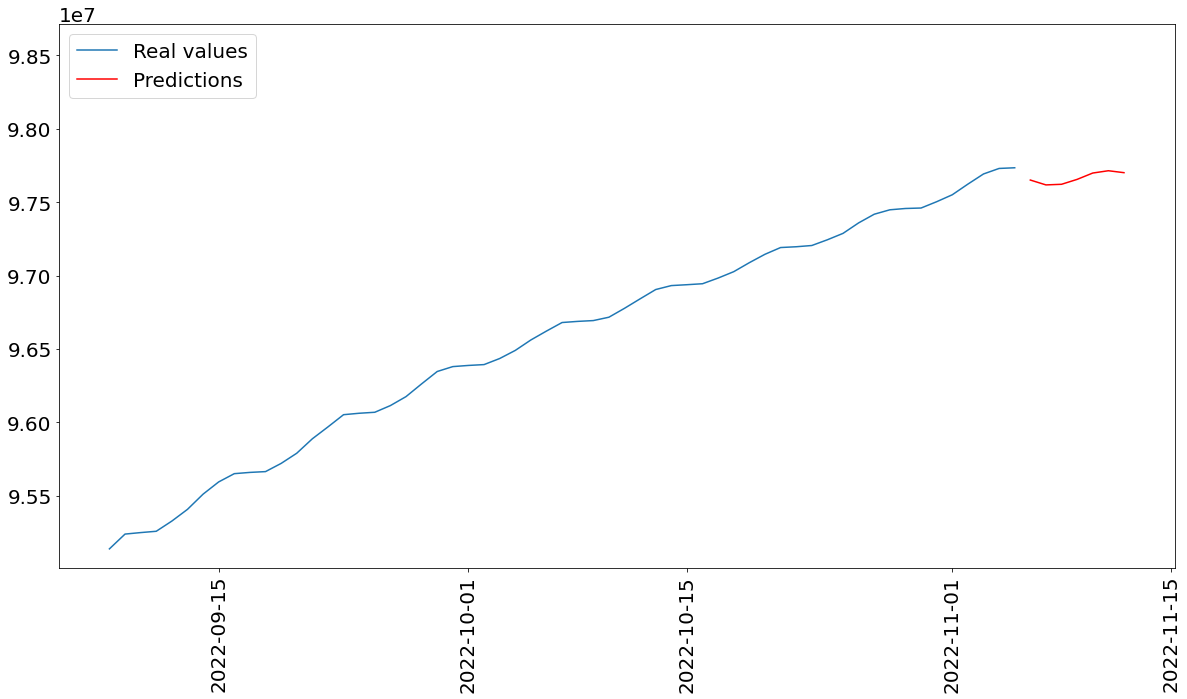

In [ ]:
plt.figure(figsize=(20, 10))
plt.rcParams['xtick.labelsize'] = 20 
plt.rcParams['ytick.labelsize'] = 20 
# plt.plot(fullAvailableDateRange1, originalData1)
plt.plot(fullAvailableDateRange1, originalData1)
plt.plot(futureDateRange, recursivePredictions, color='red')
# plt.plot(TestDateRange, newForcast2, color='red')
# lowerBound = recursivePredictions - recursiveError * recursivePredictions
# upperBound = recursivePredictions + recursiveError * recursivePredictions
# plt.fill_between(futureDateRange, lowerBound, upperBound, color='b', alpha=.1)
plt.legend(['Real values', 'Predictions'], prop={'size': 20}, loc=2)
plt.xticks( rotation=90)
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,y1,maxValue*1.01))
plt.show()

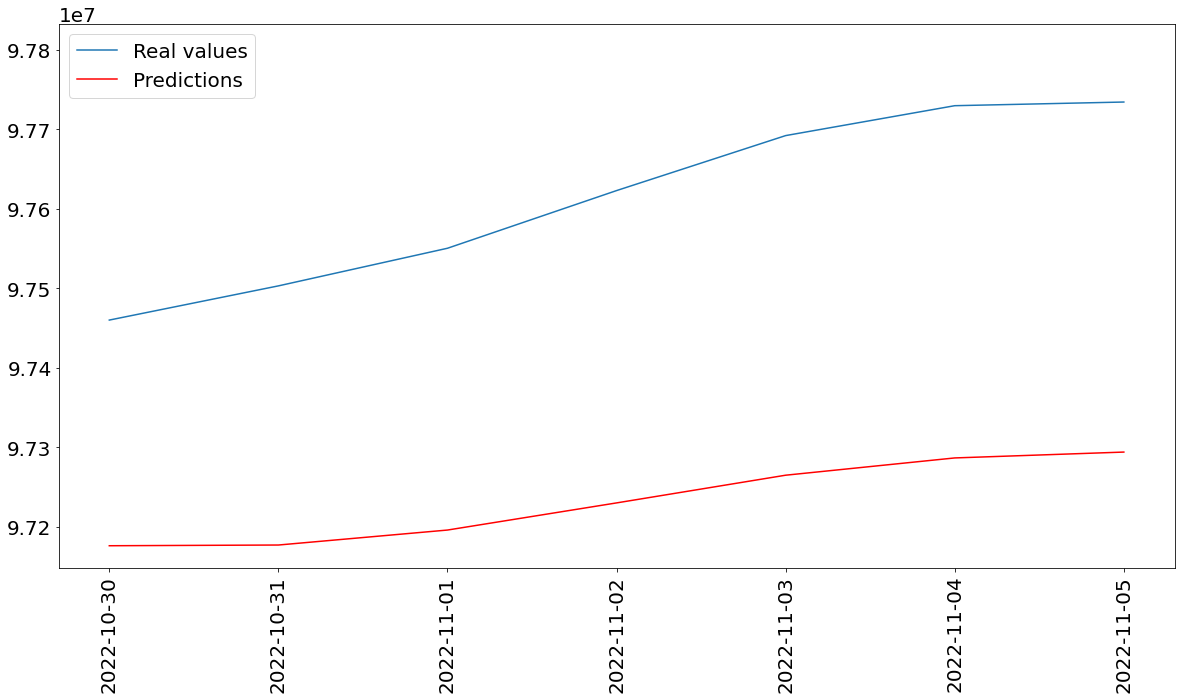

In [ ]:
plt.figure(figsize=(20, 10))
plt.rcParams['xtick.labelsize'] = 20 
plt.rcParams['ytick.labelsize'] = 20 
# plt.plot(fullAvailableDateRange1, originalData1)
plt.plot(fullAvailableDateRange2, originalData2)
# plt.plot(futureDateRange, recursivePredictions, color='red')
plt.plot(TestDateRange, newForcast2, color='red')
# lowerBound = recursivePredictions - recursiveError * recursivePredictions
# upperBound = recursivePredictions + recursiveError * recursivePredictions
# plt.fill_between(futureDateRange, lowerBound, upperBound, color='b', alpha=.1)
plt.legend(['Real values', 'Predictions'], prop={'size': 20}, loc=2)
plt.xticks( rotation=90)
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,y1,maxValue*1.001))
plt.show()

In [ ]:
print('Number of confirmed cases:')
for i, day in enumerate(futureDateRange):
    print(day.date(), ':', recursivePredictions[i])

In [ ]:
futureDateRange

[datetime.datetime(2022, 11, 5, 0, 0),
 datetime.datetime(2022, 11, 6, 0, 0),
 datetime.datetime(2022, 11, 7, 0, 0),
 datetime.datetime(2022, 11, 8, 0, 0),
 datetime.datetime(2022, 11, 9, 0, 0),
 datetime.datetime(2022, 11, 10, 0, 0),
 datetime.datetime(2022, 11, 11, 0, 0)]

In [ ]:
fullAvailableDateRange2 =fullAvailableDateRange1[-7:]

In [ ]:
originalData2 = originalData1[-7:]